In [4]:
import sim
import numpy as np
import sympy as sp
import pandas as pd
import time
import threading as thr
import keyboard
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

Epoch 1/20
180/180 - 1s - loss: 0.5915 - val_loss: 0.0968 - 959ms/epoch - 5ms/step
Epoch 2/20
180/180 - 0s - loss: 0.0289 - val_loss: 0.0107 - 198ms/epoch - 1ms/step
Epoch 3/20
180/180 - 0s - loss: 0.0079 - val_loss: 0.0066 - 199ms/epoch - 1ms/step
Epoch 4/20
180/180 - 0s - loss: 0.0053 - val_loss: 0.0047 - 202ms/epoch - 1ms/step
Epoch 5/20
180/180 - 0s - loss: 0.0037 - val_loss: 0.0033 - 201ms/epoch - 1ms/step
Epoch 6/20
180/180 - 0s - loss: 0.0026 - val_loss: 0.0023 - 202ms/epoch - 1ms/step
Epoch 7/20
180/180 - 0s - loss: 0.0019 - val_loss: 0.0016 - 199ms/epoch - 1ms/step
Epoch 8/20
180/180 - 0s - loss: 0.0015 - val_loss: 0.0014 - 200ms/epoch - 1ms/step
Epoch 9/20
180/180 - 0s - loss: 0.0012 - val_loss: 0.0010 - 196ms/epoch - 1ms/step
Epoch 10/20
180/180 - 0s - loss: 9.2200e-04 - val_loss: 9.0806e-04 - 219ms/epoch - 1ms/step
Epoch 11/20
180/180 - 0s - loss: 8.0312e-04 - val_loss: 7.4215e-04 - 202ms/epoch - 1ms/step
Epoch 12/20
180/180 - 0s - loss: 6.7722e-04 - val_loss: 5.9771e-04 - 

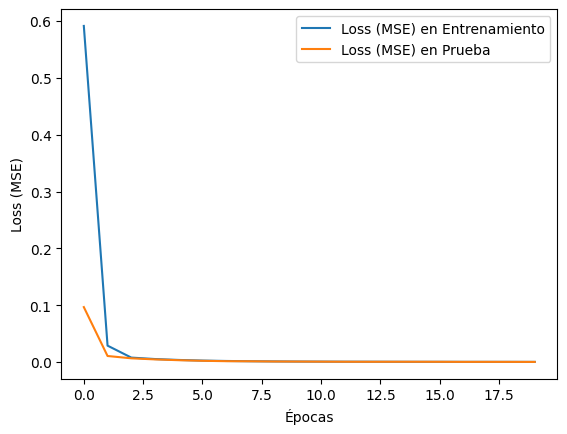

In [5]:

# Cargar el dataset
dataset = pd.read_csv('datos_entrenamiento.csv')  # Asegúrate de reemplazar 'tu_dataset.csv' con el nombre de tu archivo

# Dividir los datos en características (X) y etiquetas (y)
X = dataset[['PosX', 'PosY']].values
y = dataset[['Muslo', 'Rodilla']].values

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar los datos (escalar)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Crear el modelo de Red Neuronal Artificial (RNA)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(2,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2)  # Dos salidas para Muslo y Rodilla
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), verbose=2)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Error Cuadrático Medio (MSE): {mse}")
print(f"Coeficiente de Determinación (R^2): {r2}")

# Visualizar la pérdida durante el entrenamiento
plt.plot(history.history['loss'], label='Loss (MSE) en Entrenamiento')
plt.plot(history.history['val_loss'], label='Loss (MSE) en Prueba')
plt.xlabel('Épocas')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [17]:

def connect(port):
# Establece la conexión a CoppeliaSim
# port debe coincidir con el puerto de conexión en VREP
# retorna el número de cliente o -1 si no puede establecer conexión
    sim.simxFinish(-1) # just in case, close all opened connections
    clientID=sim.simxStart('127.0.0.1',port,True,True,2000,5) # Conectarse
    if clientID == 0: print("conectado a", port)
    else: print("no se pudo conectar")
    return clientID

# Conectarse al servidor de VREP
# *** ejecutar cada vez que se reinicia la simulación ***
clientID = connect(19999)

retCode,Dummy=sim.simxGetObjectHandle(clientID,'Dummy',sim.simx_opmode_blocking)
retCode,joint1=sim.simxGetObjectHandle(clientID,'joint1',sim.simx_opmode_blocking)
retCode,joint2=sim.simxGetObjectHandle(clientID,'joint2',sim.simx_opmode_blocking)

retCode,muslo1=sim.simxGetObjectHandle(clientID,'muslo1',sim.simx_opmode_blocking)
retCode,rodilla1=sim.simxGetObjectHandle(clientID,'rodilla1',sim.simx_opmode_blocking)

retCode,muslo2=sim.simxGetObjectHandle(clientID,'muslo2',sim.simx_opmode_blocking)
retCode,rodilla2=sim.simxGetObjectHandle(clientID,'rodilla2',sim.simx_opmode_blocking)

retCode,muslo3=sim.simxGetObjectHandle(clientID,'muslo3',sim.simx_opmode_blocking)
retCode,rodilla3=sim.simxGetObjectHandle(clientID,'rodilla3',sim.simx_opmode_blocking)

retCode,muslo4=sim.simxGetObjectHandle(clientID,'muslo4',sim.simx_opmode_blocking)
retCode,rodilla4=sim.simxGetObjectHandle(clientID,'rodilla4',sim.simx_opmode_blocking)

def BuscarInterserccion(center, radius, line_slope, line_intercept):
    a = 1 + line_slope**2
    b = -2 * center[0] + 2 * line_slope * (line_intercept - center[1])
    c = center[0]**2 + (line_intercept - center[1])**2 - radius**2

    discriminant = b**2 - 4*a*c

    if discriminant < 0:
        return []  # No intersection points

    x1 = (-b + np.sqrt(discriminant)) / (2*a)
    x2 = (-b - np.sqrt(discriminant)) / (2*a)
    y1 = line_slope * x1 + line_intercept
    y2 = line_slope * x2 + line_intercept

    return [(x1, y1), (x2, y2)]

def CrearOvaloTrayectoriaCompleta(point1, point2, distancia_a_piso, frames, levantamiento_trayectoria):
    x1, y1 = point1
    x2, y2 = point2
    
    # Calcular el ancho y la altura utilizando los puntos dados
    if x1 > x2:
        width = x1*2
    elif x1 < x2:
        width = x2*2
    height = distancia_a_piso/5
    
    # Calcular el centro del óvalo
    center_x = (x1 + x2) / 2
    center_y = (y1 + y2) / 2
    
    # Generar el óvalo utilizando las dimensiones calculadas
    theta = np.linspace(0, 2 * np.pi, frames)
    x = center_x + width/2 * np.cos(theta)
    y = center_y + height/2 * np.sin(theta)
    return x, y

def Get_Mov(largo_extremidad, altura_actual, Frames, levantamiento_trayectoria):
    # Parámetros de la circunferencia y la recta
    center = (0, 0)
    radius = largo_extremidad * 2
    line_slope = 0
    #altura_actual = 0.3

    # Encontrar puntos de intersección
    intersection_points = BuscarInterserccion(center, radius, line_slope, altura_actual)

    # Puntos que definen el óvalo
    point1 = intersection_points[0]
    point2 = intersection_points[1]

    # Crear el óvalo que pasa por los puntos dados
    #                                               , altura)
    x, y = CrearOvaloTrayectoriaCompleta(point1, point2, altura_actual, Frames, levantamiento_trayectoria)

    mov_x = []
    mov_y = []
    for i in range(len(y)):
        if y[i] <= altura_actual: # Si es menor que la distancia del robot al piso se puede elevar la pata
            mov_x.append(x[i])
            mov_y.append(y[i])

    #--------------------------------------------------------
    #
    #       aGREGAR EL ARRASTE, LA LINEA RECTA
    #
    #--------------------------------------------------------

    
    mitad = len(mov_y) // 2
    
    aux1 = [altura_actual for i in range(len(mov_y))]

    aux1 = aux1[mitad:]
    aux1_1 = aux1[:mitad]
    
    # Elimina el primer elemento del arreglo para evitar un mal comportamiento
    mov_y = mov_y[1:]
    mov_y = aux1 + mov_y + aux1_1
    aux1 = np.linspace(mov_x[len(mov_x)-1], mov_x[1], len(mov_x))
    
    # Asocia la mitad del arraste, para antes y despues de la trayectoria
    aux2 = aux1[:mitad]
    aux3 = aux1[mitad:]
    
    # Elimina el primer elemento del arreglo para evitar un mal comportamiento
    mov_x = mov_x[1:]
    mov_x = np.concatenate((aux3,mov_x))
    mov_x = np.concatenate((mov_x,aux2))
    #print("largo de MOV_X = ", len(mov_x))
    #print("largo de MOV_Y = ", len(mov_y))
    mov_y = [y - levantamiento_trayectoria for y in mov_y]
    return mov_x, mov_y

def GraficarTrayectoria(mov_x,mov_y):
    theta = np.linspace(0, np.pi, 100)
    radius = 0.4
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)

    # Dibujar el semicírculo

    plt.figure(figsize=(8, 6))  # Tamaño del gráfico
    plt.plot(mov_x,mov_y, 'ro', label='Muslo')  # Grupo 1 en rojo ('ro')
    plt.plot(x, y, 'g-', label='Alcance del extremo')
    plt.plot(0, 0, 'co', label='Muslo')

    # Convertir coordenadas polares a coordenadas cartesianas
    x = 0.2 * np.cos(theta)
    y = 0.2  * np.sin(theta)

    # Trasladar el semicírculo a la posición deseada
    x += -0.2  # Ajusta la posición en el eje x según tus necesidades
    y +=  0 # Ajusta la posición en el eje y según tus necesidades

    # Graficar el semicírculo en color purpura
    plt.fill(x, y, color='black', label='Fuera de alcance')
    plt.xlabel('Y')  # Etiqueta eje X
    plt.ylabel('X')  # Etiqueta eje Y
    plt.title('Coordenadas Juntas')  # Título del gráfico
    plt.legend()  # Mostrar leyenda

    plt.xlim(-0.4, 0.4)
    plt.ylim(-0.4, 0.4)

    plt.gca().invert_xaxis()  # Invertir eje X
    plt.gca().invert_yaxis()  # Invertir eje Y 
    # Muestra el gráfico
    plt.grid(True)  # Agregar cuadrícula
    plt.show()
    
def PredecirAngulos(mov_x, mov_y):
    coordenadas = list(zip(mov_y, mov_x))  # 
    # Normalizar las coordenadas utilizando el mismo scaler que se usó durante el entrenamiento
    coordenadas_normalizadas = scaler.transform(coordenadas)
    prediccion = model.predict(coordenadas_normalizadas)
    muslos_datos = prediccion[:, 0] # Muslo
    rodillas_datos = prediccion[:, 1] # Rodilla

    # Para restarle los 90° que molestan, de dejar bien
    muslos_datos -= 1.5
    
    return muslos_datos,rodillas_datos

def MoverBrazoPiso(x_values,y_values):
    if len(x_values) == len(y_values):
        for i in range(len(x_values)):
            retCode = sim.simxSetJointTargetPosition(clientID, joint1, x_values[i], sim.simx_opmode_oneshot) # Muslo
            retCode = sim.simxSetJointTargetPosition(clientID, joint2, y_values[i], sim.simx_opmode_oneshot) # Rodilla
            time.sleep(0.001) #delay entre cada movimiento ejemplo: 0.001
    else:
        print("La longitud de los arreglos no coinciden")

conectado a 19999


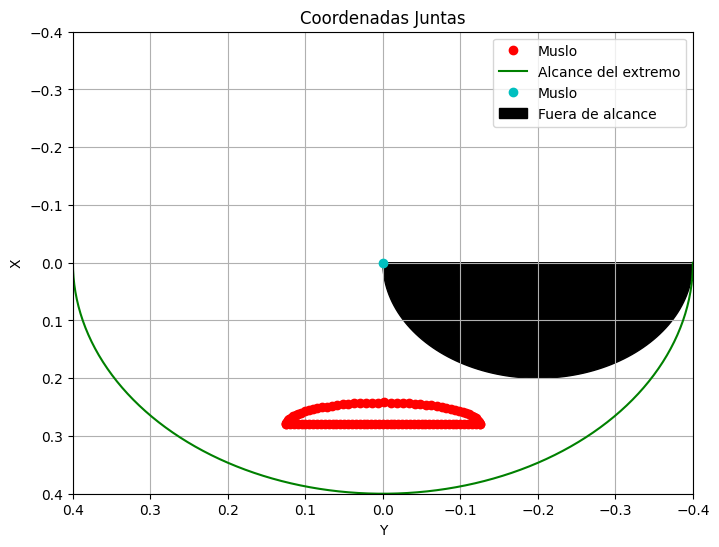

4/4 [==============================] - 0s 1ms/step


In [18]:
mov_x , mov_y = Get_Mov(0.2,0.38,100,0.1)
GraficarTrayectoria(mov_x,mov_y)
muslos_datos , rodillas_datos = PredecirAngulos(mov_x, mov_y)
MoverBrazoPiso(muslos_datos,rodillas_datos)


In [6]:
coordenadas = list(zip(mov_y, mov_x))  # 
# Normalizar las coordenadas utilizando el mismo scaler que se usó durante el entrenamiento
coordenadas_normalizadas = scaler.transform(coordenadas)
prediccion = model.predict(coordenadas_normalizadas)

4/4 [==============================] - 0s 1ms/step


In [7]:
x_values = prediccion[:, 0] # Muslo
y_values = prediccion[:, 1] # Rodilla

# Para restarle los 90° que molestan, de dajr bien
x_values -= 1.5

In [13]:
for i in range(len(x_values)):
    retCode = sim.simxSetJointTargetPosition(clientID, joint1, x_values[i], sim.simx_opmode_oneshot)
    retCode = sim.simxSetJointTargetPosition(clientID, joint2, y_values[i], sim.simx_opmode_oneshot)
    time.sleep(0.001) #delay entre cada movimiento ejemplo: 0.001